<a href="https://colab.research.google.com/github/rcb2021/ET5003_SEM1_2021-2/blob/main/ET5003_Etivity1_RayBeechinor_20201214.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<div>
<img src="https://drive.google.com/uc?export=view&id=1vK33e_EqaHgBHcbRV_m38hx6IkG0blK_" width="350"/>
</div> 

#**Artificial Intelligence - MSc**
ET5003 - MACHINE LEARNING APPLICATIONS 

###Instructor: Enrique Naredo
###ET5003_Etivity-1

In [137]:
#@title Current Date
Today = '2021-09-19' #@param {type:"date"}


In [138]:
#@markdown ---
#@markdown ### Enter your details here:
Student_ID = "20201214" #@param {type:"string"}
Student_full_name = "Raymond Beechinor" #@param {type:"string"}
#@markdown ---

In [139]:
#@title Notebook information
Notebook_type = 'Example' #@param ["Example", "Lab", "Practice", "Etivity", "Assignment", "Exam"]
Version = Final #@param ["Draft", "Final"] {type:"raw"}
Submission = True #@param {type:"boolean"}

## MNIST dataset



The MNIST database  is a dataset of handwritten digits that has been and is extensively used in machine learning. There are $10$ classes, each image is $28\times28$ pixels and, therefore, each input is $x_i\in\mathbb{R}^{784}$. 

## Task

You have to extend the code to manage any arbitrary number of classes, in other words you have to implement a general-recipe multinomial logistic classifier and Bayesian multinomial logistic classifier.

You must then select  3 digits at random and perform  the following task. 

1. Your goal is to use Bayesian multinomial logistic regression (as in the road-sign notebook) to solve this classification problem. 

2. You can downsize the training dataset (e.g., 40% training and 60%testing) if the computation of the posterior takes too much time in your computer.

3. Use the posterior uncertainty to detect the instances (digits) in the test set that are hard to classify and remove them from the test-set.

4. Then you need to compute again the accuracy of the general-recipe logistic regression on the remaining (non-difficult) instances and comment on the result.

5. In practice, the task is to use uncertainty estimation to detect the difficult instances in the test-set. This is equivalent to refuse to classify all high-uncertainty instances or, in other words, when we are uncertain we say "I don't know" and we do not return any class. In this way, you will learn how uncertainty can be used to make safer decisions, by detecting the instances that are difficult to classify.


## Introduction


As set out in the 'Task' rubric above, in this notebook, we:



1.   Download the MNIST dataset from Google Drive
2.   Select three digits from the dataset
3.   Use Scikit-Learn to perform a multinomial logistic regression on the dataset, to see how accurately it can identify the three chosen digits
4.   Perform Bayesian multinomial logistic regression on the dataset
5.   Identify digits in the test set which are "hard" to classify, i.e. those which have relatively low probability of having been correctly classified
6.  These are then removed from the test set
7.  The Scikit-Learn model from (3) above is re-run.
8.  The accuracy of the new model is compared with the original






## Libraries

In [140]:
# Suppressing Warnings:
import warnings
warnings.filterwarnings("ignore")

In [141]:
# Import libraries
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import scipy.optimize as optimize
from scipy.special import erf
import pandas as pd
import numpy as np
import seaborn as sns
from tqdm import tqdm
from skimage.io import imread, imshow
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
import arviz as az
from scipy.io import loadmat
import pymc3 as pm
import random
from IPython.display import HTML
import pickle
import theano as tt
import cv2
from sklearn.utils import shuffle
from skimage.color import rgb2gray

In [142]:
# Setting a seed:
#np.random.seed(123)

## Dataset

### Loading the MNIST dataset

In [143]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [144]:
# Path, copy the path from your Drive
# /content/drive/MyDrive/mnist
Path = '/content/drive/MyDrive/mnist/'

# MNIST Data
train_data = Path + 'mnist_train.csv'
test_data = Path + 'mnist_test.csv'

# train data
df_train = pd.read_csv(train_data)
X_train = df_train.drop("label",axis=1).values
y_train = df_train.label.values
print("Shape of training data = {}".format(X_train.shape))

# test data
df_test = pd.read_csv(test_data)
X_test = df_test.drop("label",axis=1).values
y_test = df_test.label.values
print("Shape of test data = {}".format(X_test.shape))

Shape of training data = (60000, 784)
Shape of test data = (10000, 784)


In [145]:
# Normalizing the Inputs:
X_train = X_train/255
X_test = X_test/255

# Printing the new input range of values:
minv = np.min(X_train)
maxv = np.max(X_train)
print(minv,maxv)

0.0 1.0


### Description of Data:

In [146]:
# Number of examples
n_train =  len(X_train)
n_test =  len(X_test)

# Shape of an traffic sign image
image_shape = X_train.shape[1]

# unique classes/labels in the training dataset.
alltotal = set(y_train)
n_classes = len(alltotal)

print("Number of Training examples =", n_train)
print("Number of Test examples =", n_test)
print("Image input shape =", image_shape)
print("Number of classes =", n_classes)

Number of Training examples = 60000
Number of Test examples = 10000
Image input shape = 784
Number of classes = 10


In [147]:
# Pick 10 random images from the training data to display
npRandomImages = np.random.choice(X_train.shape[0],10, replace=False)

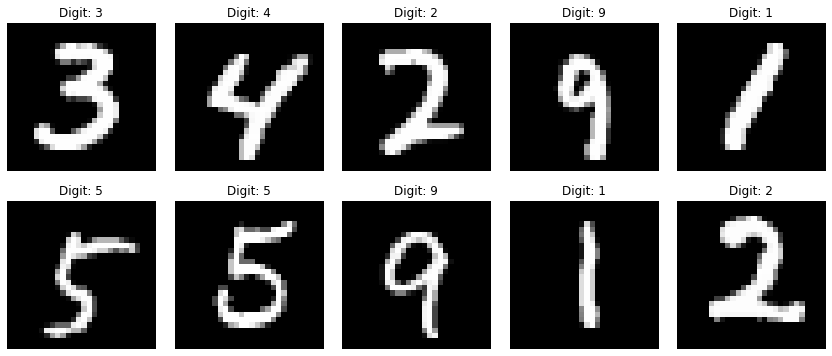

In [148]:
# Display these 10 digits
fig, axs = plt.subplots(2,5, figsize=(15, 6))
fig.subplots_adjust(hspace = .2, wspace=.001)
iCount = 0
axs = axs.ravel()
for iIndex in npRandomImages:
  image = X_train[iIndex]
  axs[iCount].axis('off')
  pixels = X_train[iIndex].reshape((28,28))
  axs[iCount].imshow(pixels,cmap="Greys_r")
  axs[iCount].set_title("Digit: {}".format(y_train[iIndex].astype(int)))
  iCount+=1
    

### Class Distribution:

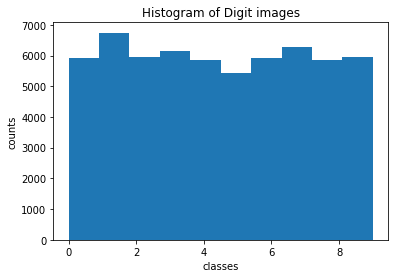

In [149]:
fig, ax = plt.subplots()
ind = np.arange(n_classes)

n, bins, patches = ax.hist(y_train, n_classes)
ax.set_xlabel('classes')
ax.set_ylabel('counts')
ax.set_title(r'Histogram of Digit images')
plt.show()

Commentary:
We see from the histogram above that the dataset is reasonably balanced, with between roughly 6000 and 7000 examples of each of the ten classes of digit in the dataset

## Downsampling

### Randomly selecting 3 of the 10 Digit Classes

In [150]:
# We select the number of Classes we want:
#n_classes = 
n_classes = 3

# Empty list to append the random digit classes we select:
classes = []

# We select 3 digits at random and make sure they are unique:
while len(classes) < n_classes:
    
    # Randomly drawing a digit from 0-9:
    num2choose = np.random.randint(0,10)

    # Append the digit if it's not already in our list of classes:
    if num2choose not in classes: 
        classes.append(num2choose)
        
        
# Sorting the Classes smallest to largest    
classes.sort()
# print classes selected
# 'classes' is a list of integers; create a list of strings for printing
lClassesAsStrings = [str(iClass) for iClass in classes]

print("Digits selected for classification: {}".format(", ".join(lClassesAsStrings)))

Digits selected for classification: 3, 4, 5


In [151]:
# The number of instances we'll keep for each of our 3 digits:
inst_class = 500

inputs = []
labels = []
# Loop to randomly sample the instances for each digit:
for r in classes:
    imgs = X_train[np.where(y_train==r)[0],:]
    inputs.append(imgs[np.random.permutation(imgs.shape[0]),:][0:inst_class,:])
    labels.append(np.ones(inst_class)*r)
    
# Shaping inputs and labels in the right format    
X_train = np.vstack(inputs).astype(np.float64)
y_train = np.hstack(labels)

In [152]:

print("Shape of training features: {}".format(X_train.shape))
print("Shape of training labels: {}".format(y_train.shape))

Shape of training features: (1500, 784)
Shape of training labels: (1500,)


New Classes Distribution

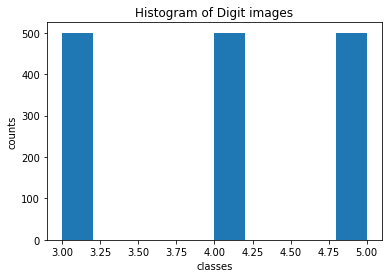

In [153]:
# new histogram
fig, ax = plt.subplots()
n_classes = len(set(y_train))
ind = np.arange(n_classes)

ax.hist(y_train,bins=10)
ax.set_xlabel('classes')
ax.set_ylabel('counts')
ax.set_title(r'Histogram of Digit images')
plt.show()

Commentary: The histogram above shows the three classes we are using are evenly balanced

In [154]:
# plot digits
def plot_digits(instances, images_per_row=5, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image,  cmap='gist_yarg', **options)
    plt.axis("off")

Text(0.5, 1.0, 'Some images from our three selected classes')

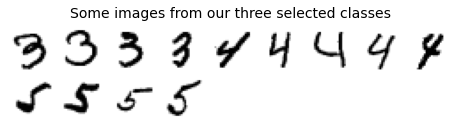

In [155]:
# Show a few instances from each Digit:
plt.figure(figsize=(8,8))
label_indices = np.array([iIndex for iIndex in range(100,1400,100)])

# Plotting 'original' image
plot_digits(X_train[label_indices,:],images_per_row=9)
plt.title("Some images from our three selected classes", fontsize=14)

###  Splitting the Training data into both Training and Validation Sets:

- Although this is the Training set, we can still set aside some samples (for instance 20%) of the 1,500 instances we have for Model Validation purposes.


- With that Validation Set, we can then select the amount of Uncertainty we are happy with from our Model to use out of sample on other unseen data.


- We can then test out how well our decision performs on the Test Set that we put aside earlier.

In [156]:
### Split tha dataset in training and validation sets
# choose the fraction of your validation data from the training set
w = 0.20
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=w, random_state=0)
 
# Shuffling the training instaces around to randomize the order of inputs to the model:
X_train, y_train = shuffle(X_train, y_train)

In [157]:
# print shape of your validation and training set

print("Shape of training features: {}".format(X_train.shape))
print("Shape of test features: {}".format(X_val.shape))
print("Shape of training labels: {}".format(y_train.shape))
print("Shape of test labels: {}".format(y_val.shape))

Shape of training features: (1200, 784)
Shape of test features: (300, 784)
Shape of training labels: (1200,)
Shape of test labels: (300,)


### Encoding the Class labels for the Probabilistic ML Model:

This is an example:

- **[1,0,0]** for first digit
- **[0,1,0]** for second digit
- **[0,0,1]** for third digit

### General-Recipe ML

In [158]:
# model
model_log = LogisticRegression(random_state=0, max_iter=2000, C=100, solver='lbfgs', multi_class='multinomial').fit(X_train,y_train)

# Classification:
y_pred_log = model_log.predict(X_val)
y_pred_logi_prob = model_log.predict_proba(X_val)
prob_classmax = np.max(y_pred_logi_prob,axis=1)
# Maybe taking the maximum probability 
# in any of the classes for each observation


# Computing the Accuracy:
print("Accuracy of Scikit-Learn Multinomial Logistic Regression model = {}".format(accuracy_score(y_pred_log, y_val)))
npProbabilities=np.sort(prob_classmax)
fMostUncertainScore = npProbabilities[0]
fMostCertainScore   = npProbabilities[-1]
print("Probability of accuracy in most uncertain case: {}".format(fMostUncertainScore))
print("Probability of accuracy in most certain   case: {}".format(fMostCertainScore))


Accuracy of Scikit-Learn Multinomial Logistic Regression model = 0.9466666666666667
Probability of accuracy in most uncertain case: 0.4647601596099562
Probability of accuracy in most certain   case: 1.0


### Probabilistic Multinomial Logistic Regression:

In [159]:
import sklearn.preprocessing

The Multinomial Logistic Regression has some parameters:

- $\alpha$, which is the intercept term:

- $\beta$, which is a vector of coefficients which give a weighting to the importance of each input feature:


In [160]:
classes

[3, 4, 5]

In [161]:
y_2_bin = sklearn.preprocessing.LabelBinarizer().fit_transform(y_train.reshape(-1,1))
nf = X_train.shape[1]
# number of classes
nc = len(classes)
# floatX = float32
floatX = tt.config.floatX

init_b = np.random.randn(nf, nc-1).astype(floatX)
init_a = np.random.randn(nc-1).astype(floatX)


with pm.Model() as multi_logistic:
    # Prior
    β = pm.Normal('beta', 0, sigma=100, shape=(nf, nc-1), testval=init_b)
    α = pm.Normal('alpha', 0, sigma=100, shape=(nc-1,), testval=init_a)
    
    # we need to consider nc-1 features because the model is not identifiable
    # the softmax turns a vector into a probability that sums up to one
    # therefore we add zeros to go back to dimension nc
    # so that softmax returns a vector of dimension nc
    β1  = tt.tensor.concatenate([np.zeros((nf,1)),β ],axis=1)
    α1  = tt.tensor.concatenate([[0],α ],)
    
    # Likelihood
    mu = pm.math.matrix_dot(X_train,β1) + α1
    # It doesn't work if the problem is binary
    p = tt.tensor.nnet.nnet.softmax(mu)
    observed = pm.Multinomial('likelihood', p=p, n=1, observed=y_2_bin)



In [162]:
with multi_logistic:
  approx = pm.fit(30000, method='advi')

Finished [100%]: Average Loss = 5,210.5


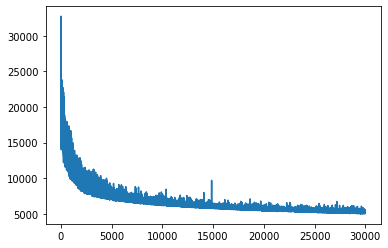

In [163]:
plt.plot(approx.hist)

In [164]:
dd = 300
posterior = approx.sample(draws=dd)

test image #228
posterior sample #200
true class= 3.0
classes: [3, 4, 5]
estimated prob= [0.99989791 0.         0.00010209]


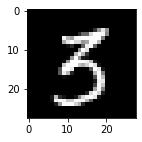

In [165]:
## The softmax function transforms each element of a collection by computing the exponential
#  of each element divided by the sum of the exponentials of all the elements.
from scipy.special import softmax

#select an image in the test set
i = 10 
i = random.randint(0, dd)

#select a sample in the posterior
s = 100 
s = random.randint(0, dd)


beta  = np.hstack([np.zeros((nf,1)),  posterior['beta'][s,:] ])
alpha = np.hstack([[0],  posterior['alpha'][s,:] ])
image = X_val[i,:].reshape(28,28)
plt.figure(figsize=(2,2))
plt.imshow(image,cmap="Greys_r")
np.set_printoptions(suppress=True)

print("test image #" + str(i))
print("posterior sample #" + str(s))
print("true class=", y_val[i])
print("classes: " + str(classes))
print("estimated prob=",softmax((np.array([X_val[i,:].dot(beta) + alpha])))[0,:])

In [166]:
y_pred_Bayesian = []
for i in range (X_val.shape[0]):
  val = np.zeros((1,len(classes)))

  for s in range(posterior['beta'].shape[0]):
    beta = np.hstack([np.zeros((nf,1)), posterior['beta'][s,:]])
    alpha = np.hstack([[0], posterior['alpha'][s,:]])
    val = val + softmax((np.array([X_val[i,:].dot(beta) + alpha])))

  fMeanProbability = val/posterior['beta'].shape[0]
  y_pred_Bayesian.append(np.argmax(fMeanProbability))

In [167]:
fBayesianAccuracy = accuracy_score(np.array(classes)[y_pred_Bayesian],y_val)
print("Accuracy of Bayesian model = {}".format(fBayesianAccuracy))

Accuracy of Bayesian model = 0.95


In [168]:
y_predB=[]

for i in range(X_val.shape[0]):
    #print(i)
    val=[]

    for s in range(posterior['beta'].shape[0]):
        beta = np.hstack([np.zeros((nf,1)),  posterior['beta'][s,:] ])
        alpha = np.hstack([[0],  posterior['alpha'][s,:] ])
        val.append(softmax((np.array([X_val[i,:].dot(beta) + alpha])))[0,:])

    #mean probability
    valmean = np.mean(val,axis=0)
    #class with maximum mean probability
    classmax = np.argmax(valmean)
    #ranks
    ranks = np.array(val.copy())
    ranks   = ranks  *0 #init
    colmax = np.argmax(np.array(val),axis=1)
    ranks[np.arange(0,len(colmax)),colmax]=1
     
    y_predB.append( [classmax, valmean[classmax], np.std(ranks,axis=0)[classmax]])

    
y_predB= np.array(y_predB)

In [169]:
mm = 10
y_predB[0:mm,:]

array([[0.        , 0.99993569, 0.        ],
       [0.        , 0.99972259, 0.        ],
       [2.        , 0.99163955, 0.08137704],
       [0.        , 0.85365329, 0.32496154],
       [2.        , 0.50957724, 0.49998889],
       [2.        , 0.78818267, 0.40491426],
       [1.        , 0.93904169, 0.22469733],
       [0.        , 0.99981069, 0.        ],
       [0.        , 0.9999994 , 0.        ],
       [2.        , 0.73927137, 0.42909465]])

In [170]:
#sorting in descending order
difficult = np.argsort(-y_predB[:,2])
y_predB[difficult[0:mm],:]

array([[1.        , 0.49985595, 0.49998889],
       [2.        , 0.50957724, 0.49998889],
       [2.        , 0.49949576, 0.49998889],
       [0.        , 0.47890916, 0.49989999],
       [0.        , 0.54323741, 0.49888765],
       [0.        , 0.45854633, 0.49865374],
       [2.        , 0.53423877, 0.49811868],
       [2.        , 0.54300908, 0.49638695],
       [2.        , 0.55420307, 0.49638695],
       [2.        , 0.56867014, 0.49553562]])

In [171]:
easy = np.argsort(y_predB[:,2])
print("Accuracy in easy instances =", accuracy_score(y_pred_log[easy[0:100]], y_val[easy[0:100]]))

difficult = np.argsort(-y_predB[:,2])
print("Accuracy in difficult instances =", accuracy_score(y_pred_log[difficult[0:100]], y_val[difficult[0:100]]))

Accuracy in easy instances = 1.0
Accuracy in difficult instances = 0.84


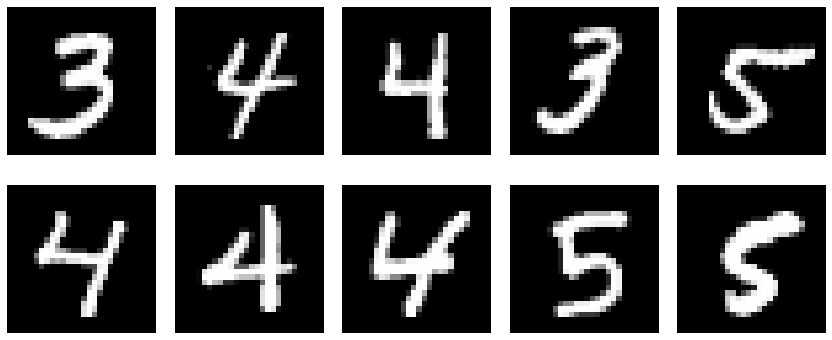

In [172]:
# show 10 random 'easy' images
fig, axs = plt.subplots(2,5, figsize=(15, 6))
fig.subplots_adjust(hspace = .2, wspace=.001)
axs = axs.ravel()

for i in range(10):
    index = easy[i]
    image = X_val[index,:].reshape(28,28)
    axs[i].axis('off')
    axs[i].imshow(image,cmap="Greys_r")
    

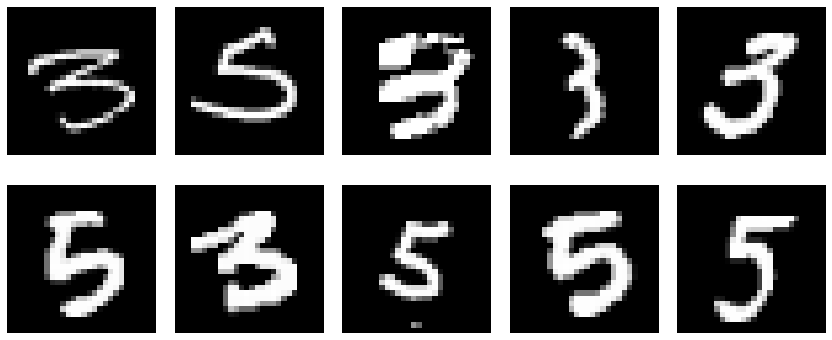

In [173]:
# show 10 random 'difficult' images
fig, axs = plt.subplots(2,5, figsize=(15, 6))
fig.subplots_adjust(hspace = .2, wspace=.001)
axs = axs.ravel()
for i in range(10):
    index = difficult[i]
    image = X_val[index,:].reshape(28,28)
    axs[i].axis('off')
    axs[i].imshow(image,cmap="Greys_r")
    

In [174]:
for iNumSamples in [1, 200, 250]:
    npUpdated_X_val = np.delete(X_val, difficult[0:iNumSamples], axis=0)
    npUpdated_Y_val = np.delete(y_val, difficult[0:iNumSamples], axis=0)
    npUpdated_y_pred = model_log.predict(npUpdated_X_val)
    fNewAccuracy = accuracy_score(npUpdated_y_pred, npUpdated_Y_val)
    print("New Accuracy Score for General Recipe Sklearn Multinomial Logistic Regression with {} difficult examples removed: {}".format(iNumSamples,fNewAccuracy))



New Accuracy Score for General Recipe Sklearn Multinomial Logistic Regression with 1 difficult examples removed: 0.9464882943143813
New Accuracy Score for General Recipe Sklearn Multinomial Logistic Regression with 200 difficult examples removed: 1.0
New Accuracy Score for General Recipe Sklearn Multinomial Logistic Regression with 250 difficult examples removed: 1.0


## Summary

This e-tivity was an introduction to the use of probabilistic methods in machine learning.  In this run, we see that when asked to identify the digits 1, 3, and 5 from the MNIST dataset, the general-purpose multinomial logistic regression model from the Scikit-learn library had an accuracy of 0.946.  We saw that when a Bayesian multinomial probabilistic model from the PyMC3 library was used on the same data, its overall accuracy was 0.95.  We saw that the accuracy of the Bayesian model was 0.84 in the cases of the most difficult-to-classify images, rising to 1.0 for the easiest cases.  We also saw how removing difficult images from the validation dataset increases the accuracy of the general-purpose Scikit-learn model.

Discussions with team-mates focussed, *inter alia* on the commentary in the template about the probabilistic model not being identifiable and what that meant for the code, specifically the need to consider one fewer feature.  

It was interesting to visualise 10 digits which the model considered 'easy' and compare them with digits it considered 'difficult'.  To the human eye, some of the 'difficult' images appear obvious.  This illustrates the powerful influence of the composition of the training data on the behaviour of the final model.

In the course of working on this E-tivity, I attempted to experiment in greater detail with the PyMC3 library.  However, I found that the runtimes associated with sampling the training data were surprisingly long - of the order of two hours.  Hence I did not include this code in this submission.  It would have been useful to have explored PyMC3 in greater detail to understand how to 'train' a model and use it to generate predictions in a use-case such as this one.

## References




How to Predict New Values on Hold-out Data - Questions [online] (2019) PyMC Discourse, available: https://discourse.pymc.io/t/how-to-predict-new-values-on-hold-out-data/2568/2 [accessed 19 Sep 2021].


Kübler, D.R. (2021) Bayesian Linear Regression in Python via PyMC3 [online], Medium, available: https://towardsdatascience.com/bayesian-linear-regression-in-python-via-pymc3-ab8c2c498211 [accessed 19 Sep 2021].


Prior and Posterior Predictive Checks — PyMC3 3.10.0 Documentation [online] (2021) available: https://docs.pymc.io/notebooks/posterior_predictive.html [accessed 19 Sep 2021].


Salvatier, J., Wiecki, T.V., Fonnesbeck, C. (2016) ‘Probabilistic programming in Python using PyMC3’, PeerJ Computer Science, 2, e55.

